# Imports

In [1]:
# Imports for JupyterLite
try:
    import piplite
    await piplite.install(['ipywidgets'])
except ImportError:
    pass

#!pip install gspread
import gspread

#!pip install --upgrade ipywidgets
import ipywidgets as widgets
# Utils widgets
from ipywidgets import Button, Layout, jslink, IntText, IntSlider, Box, HBox, VBox, GridspecLayout

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

import matplotlib.pyplot as plt
import numpy as np
import re

# Debug

In [2]:
#debug functions
class debugger:
    debug_str = ''
    
    def __init__(self):
        self.debug_str = ''
        
    def debug_log(self, text):
        if debug == True:
            self.debug_str = self.debug_str + str(text)
            print(text)
            return
        
    def clear_log(self):
            self.debug_str = ''
            print('debug log cleared')
            return

In [3]:
#initializes debugger
db = debugger()
#turns printing to debug log on (True) or off (False)
debug = True

# Box Utility

In [4]:
def VBox(*pargs, **kwargs):
    """Displays multiple widgets vertically using the flexible box model."""
    box = Box(*pargs, **kwargs)
    box.layout.display = 'flex'
    box.layout.flex_flow = 'column'
    box.layout.align_items = 'stretch'
    return box

def HBox(*pargs, **kwargs):
    """Displays multiple widgets horizontally using the flexible box model."""
    box = Box(*pargs, **kwargs)
    box.layout.display = 'flex'
    box.layout.align_items = 'stretch'
    return box

def add_widget_to_Box(widget, Box):
    box_children_list = list(Box.children)
    box_children_list.append(widget)
    Box.children = tuple(box_children_list)
    return

def remove_widget_from_Box(widget, Box):
    box_children_list = list(Box.children)
    box_children_list.remove(widget)
    Box.children = tuple(box_children_list)
    return

def remove_last_widget_from_Box(Box):
    box_children_list = list(Box.children)
    box_children_list.pop()
    Box.children = tuple(box_children_list)
    return

# Main interface and filter functions

In [5]:
class filter_ui:
    #google sheet variables
    google_sa = None
    sheet = None
    worksheet = None
    
    #change these values to change which sheet and worksheet you want to open
    sheet_name = "Venus Blood Savior"
    worksheet_name = "Recruitable Units"
    other_worksheet_names = ["Talismans","Equipment"]
    other_worksheet_dfs = None
    
    """
    in the form:
    'skill_name': [
        "attack_bonus_percentage",
        "defense_bonus_percentage",
        "speed_bonus_percentage",
        "wisdom_bonus_percentage",
        "damage_bonus_percentage",
        "damage_reduction_percentage"
        ]
    make sure all 6 slots are at least filled with 0 for no value or function will break
    """
    skill_dict = {'skill1': [10, 20, 30, 40, 50, 60],
                  'skill2': [15, 25, 35, 45, 55, 65]
                 }
    
    #dataframe variables
    unit_df = None
    filter_df = None
    
    #widget variables
    sheet_name_label = None
    filter_section_label = None
#     add_category_button = None

    #teambuilder variables
    teambuilder = None
    teambuilder_section_VBox = None
    
    #layout variables
#     header_section_VBox = None # for expanding header in the future possibly
    filter_section_VBox = None
    wrapper_VBox = None
    
    #layout helper variables
    filter_rows = None
    
    #category option variables
#     valid_categories = []
    forbidden_categories = ['Name']
#     selected_categories = None
#     selected_tags= []

    filter_dict = None
    
    #for displayng output
    out = None
    
    def __init__(self):
        
        """
        begin code for importing google sheets
        
        follow these tutorials for to set up google sheets yourself:
        https://ploomber.io/blog/gsheets/
        https://towardsdatascience.com/from-google-sheet-to-your-jupyter-notebook-ccdbf28fbf1b

        share any sheets you want to use with the service email you made from the tutorial (make sure to give edit permissions)
            should look like: list-381@list-380300.iam.gserviceaccount.com

        sheetname: change this to the name of the spreadsheet you want to open
        worksheetname: change this to the name of the spreadsheet tab/worksheet you want to open
        """

        #use the service account file to authenticate, download this file to your pc in the same folder as this jupyter notebook
        self.google_sa = gspread.service_account(filename="list-380300-d89958bc04be.json")
        
        self.sheet = self.google_sa.open(self.sheet_name)
        self.worksheet = self.sheet.worksheet(self.worksheet_name)
        
        self.other_worksheet_dfs = {}
        for name in self.other_worksheet_names:
            df = pd.DataFrame(self.sheet.worksheet(name).get_all_records())
            self.other_worksheet_dfs.update({name: df})
#         db.debug_log(self.other_worksheet_dfs)

        self.unit_df = pd.DataFrame(self.worksheet.get_all_records())
        
        #end code for importing google sheets
        
        self.sheet_name_label = widgets.Label(
            value="Sheet Name: " + self.sheet_name,
            style=dict(
                font_size='64',
                font_weight='bold')
        )
        
        self.filter_section_label = widgets.Label(
            value="Filters:",
            style=dict(
                font_size='64',
                font_weight='bold')
        )

#         self.add_category_button = widgets.Button(
#                 description='Add category',
#                 disabled=False,
#                 button_style='info', # 'success', 'info', 'warning', 'danger' or ''
#                 tooltip='Click to add category',
#                 icon='plus', # (FontAwesome names without the `fa-` prefix)
#                 layout=Layout(height='auto', width='auto')
#         )
        
#         self.selected_categories = []
        self.filter_dict = {}
        
        self.filter_rows = []
        new_filter_row = filter_row(self, 0, self.create_valid_category_list())
        self.filter_rows.append(new_filter_row)
        self.filter_section_VBox = VBox(children=[new_filter_row.wrapper_VBox])
#         self.filter_rows.append(filter_row(self, 0, self.create_valid_category_list()))
#         self.filter_section_VBox = VBox(children=[self.filter_rows[0].wrapper_VBox])
        
        self.teambuilder = teambuilder(self)
        
        self.wrapper_VBox = VBox(children=[self.sheet_name_label,
                                           self.teambuilder.wrapper_VBox,
                                           self.filter_section_label,
                                           self.filter_section_VBox])
#         self.wrapper_VBox = VBox(children=[self.sheet_name_label, self.add_category_button, self.filter_section_VBox])
        
        #add event handlers
#         self.add_category_button.on_click(self.add_filter_row)
        
    #event handler functions
    def add_filter_row(self,button):
        if self.is_categories_all_selected():
            new_filter_row = filter_row(self, len(self.filter_rows), self.create_valid_category_list())
            self.filter_rows.append(new_filter_row)
            add_widget_to_Box(new_filter_row.wrapper_VBox, self.filter_section_VBox)
#             self.filter_rows.append(filter_row(self, len(self.filter_rows), self.create_valid_category_list()))
#             add_widget_to_Box(self.filter_rows[(len(self.filter_rows)-1)].wrapper_VBox, self.filter_section_VBox)
        
    #check if categories in filter rows have all been selected
    def is_categories_all_selected(self):
        if len(self.create_valid_category_list()) == 0:
            return False
        for filter_row in self.filter_rows:
            if filter_row.category_combobox.disabled == False:
                return False
        return True
        
    #data operation functions
    def get_unique_characters(self, s):
        # Convert each array to a list of strings and join them
        joined_str = ''.join([','.join(x) for x in s.tolist()])
        # Split the resulting string into individual characters and get the unique ones
        return list(set(joined_str))

    def get_unique_strings(self, column_name):
        column=self.unit_df[column_name].str.split(',')

        # flatten the arrays into a single list of strings
        flat_column = column.explode().tolist()

        # preprocess the strings to remove numbers in square brackets
        flat_column = [re.sub(r'\[\d+\]', '', s) for s in flat_column]

        # extract unique values and convert to list
        unique_strings = pd.unique(flat_column).tolist()

        return unique_strings
    
    def get_skills_by_category(self, worksheet_name, category, value):
        """
        Returns a list of possible skills that a letter growth rate can use.
        Args:
            worksheet_name (str): The name of the worksheet to search for the value in, ex. 'Growth Rate'
            value: The value to search for, ex. 'E' for growth rate
        Returns:
            skills (list): A list of possible skills that the growth rate can use.
        """
        # Filter the DataFrame to only include rows with the specified growth rate
        df = self.other_worksheet_dfs[worksheet_name]
        
        skills_df = df[df[category] == value]

        # Extract the Skill column from the filtered DataFrame
        skills = skills_df['Skills'].tolist()

        return skills
    
    def get_possible_skills(self, **kwargs):
        """
        Returns an array of all possible skills looking in growth rate talismans and equipment slots.
        Args:
            kwargs: keyword argument where the dictionary key gives the value, pass in args in the form: "slot = '片手'"
        Returns:
            skills (set): An set of skills that are possible.
        """
        
        talisman_skills = self.get_skills_by_category(kwargs['wkst_1'], kwargs['cat_1'], kwargs['growth_rate'])
        t_skills_set = set(talisman_skills)
        
        slot_skills = self.get_skills_by_category(kwargs['wkst_2'], kwargs['cat_2'],kwargs['slot'])
        s_skills_set = set(slot_skills)
        
        skills_set = t_skills_set.union(s_skills_set)
        
        return skills_set
    
#     def get_data_from_filter_rows(self):
# #         db.debug_log(self.filter_rows)
#         self.filter_dict = {}
#         for filter_row in self.filter_rows:
#             self.filter_dict.update({filter_row.category_combobox.value: filter_row.current_tags})
# #         db.debug_log('get data end')
# #         db.debug_log(self.filter_dict)

#     def filter_df_by_selected_tags(self, df):
#         self.filter_df=df
#         self.get_data_from_filter_rows()
#         #db.debug_log(self.filter_rows)
#         for category in self.filter_dict:
#             for tag in self.filter_dict[category]:
#                 self.filter_df = self.filter_df[self.filter_df[category].str.contains(tag)]
# #         db.debug_log('filter attempt end')

    def filter_df_by_selected_tags(self, df):
        self.filter_df=df
        #db.debug_log(self.filter_rows)
        for tag in self.filter_rows[0].current_tags:
            category = self.filter_rows[0].current_tags[tag]
            self.filter_df = self.filter_df[self.filter_df[category].str.contains(tag)]
#         db.debug_log('filter attempt end')

    """
    returns an array of effective stats:
    effective stats = [
        effective_attack,
        effective_defense,
        effective_speed,
        effective_wisdom,
        effective_damage_bonus,
        effective_damage_reduction]
    """
    def calculate_effective_stats(self, unit):
        unit_row =  ui.unit_df.loc[(ui.unit_df["Name"]==unit)]
#         display(unit_row)
        print(unit_row.at[1,"Attack"])
        unit_stats = {
            "Attack": unit_row.at[1,"Attack"],
            "Defense": unit_row.at[1,"Defense"],
            "Speed": unit_row.at[1,"Speed"],
            "Wisdom": unit_row.at[1,"Wisdom"],
            "Damage Bonus": 0,
            "Damage Reduction": 0
        }
        unit_skill_bonuses = self.get_skills_from_unit(unit)
        effective_stats = {
            "Attack": unit_row.at[1,"Attack"],
            "Defense": unit_row.at[1,"Defense"],
            "Speed": unit_row.at[1,"Speed"],
            "Wisdom": unit_row.at[1,"Wisdom"],
            "Damage Bonus": 0,
            "Damage Reduction": 0
        }
        for skill in unit_skill_bonuses:
            bonuses = unit_skill_bonuses[skill]
            
            effective_stats["Attack"] = (effective_stats["Attack"] * bonuses[0])
            effective_stats["Defense"] = (effective_stats["Defense"] * bonuses[1])
            effective_stats["Speed"] = (effective_stats["Speed"] * bonuses[2])
            effective_stats["Wisdom"] = (effective_stats["Wisdom"] * bonuses[3])
            effective_stats["Damage Bonus"] = (effective_stats["Damage Bonus"] * bonuses[4])
            effective_stats["Damage Reduction"] = (effective_stats["Damage Reduction"] * bonuses[5])
        return effective_stats

    def get_skills_from_unit(self, unit):
        unit_skills = self.skill_dict
        return unit_skills
    
#     #valid category selection option filtering functions
#     def is_valid_category(self, category):
#         if category not in self.forbidden_categories and category not in self.selected_categories:
#     #         db.debug_log('valid')
#             return True
#     #     db.debug_log('not valid')
#         return False
    
    #valid category selection option filtering functions
    def is_valid_category(self, category):
        if category not in self.forbidden_categories:
    #         db.debug_log('valid')
            return True
    #     db.debug_log('not valid')
        return False
    
    def create_valid_category_list(self):
        non_numeric_columns=self.unit_df.select_dtypes(exclude=[np.number]).columns.tolist()
        valid_categories = []
        for column in non_numeric_columns:
            if self.is_valid_category(column):
                valid_categories.append(column)
        return valid_categories
    
    #filter selectable tags by category function
    def get_tags_of_category(self, category):
    #     db.debug_log('getting tags of category')
        category_tags = self.get_unique_strings(category)
        return category_tags
    
    """
    KANOUE CODE BELOW
    """
    
    def parse_by_delimiter(self, string,delimiter):
        return string.split(delimiter)

    def get_unit_stat_as_string_array(self, unit_name,stat_column_name):
        unit_row = self.unit_df[self.unit_df['Name'] == unit_name]
        stat_string = unit_row.squeeze()[stat_column_name]
        unit_stat = stat_string.split(',')
        return unit_stat

    def get_unit_buff_skills(self, unit_name):
        unit_skills = self.get_unit_stat_as_string_array(unit_name,"Skills")

        search_terms = ['活性', '指揮', '支配']
        buff_skills = [skill for skill in unit_skills if any(term in skill for term in search_terms)]
        return buff_skills

    def get_buff_skills_by_skill_list(self, skill_list):
        search_terms = ['活性', '指揮', '支配']
        buff_skills = [skill for skill in skill_list if any(term in skill for term in search_terms)]
        return buff_skills

    def get_modifier_type(self, buff_skill):
        search_terms = ['活性', '指揮', '支配']
        for term in search_terms:
            if term in buff_skill:
                if (term == "活性") or (term == "支配"):
                    return "Flat Stats"
                elif term == "指揮":
                    return "Stats Multiplier"

    def get_modifier_value(self, buff_skill):
        search_terms = ['活性', '指揮', '支配']
        for term in search_terms:
            if term in buff_skill:
                skill_value_string = buff_skill.split(term)[1]
                chars_to_remove = ['[', ']']
                for char in chars_to_remove:
                    skill_value_string = skill_value_string.replace(char, '')
                return int(skill_value_string)

    def get_requirement_type(self, buff_skill):
        unique_elements = self.get_unique_strings("Element")
        unique_races = self.get_unique_strings("Race")
        if any(element in buff_skill for element in unique_elements):
            return "Required Element"
        elif any(race in buff_skill for race in unique_races):
            return "Required Race"
        else: 
            return "Default Effects"

    def initialize_modifier_entry(self, modifier_type,modifier_dict):
        if modifier_type == "Flat Stats":
            modifier_dict[modifier_type] = 0
        elif modifier_type == "Stats Multiplier":
            modifier_dict[modifier_type] = 1

    def stack_modifier_value(self, modifier_type,modifier_value,modifier_dict):
        if modifier_type == "Flat Stats":
            modifier_dict[modifier_type] += modifier_value
        elif modifier_type == "Stats Multiplier":
            modifier_dict[modifier_type] *= 1 + modifier_value/100

    def add_buff_skill_effects_to_unit_buff_stats(self, buff_skill,unit_buff_effects):   

        requirement_type = self.get_requirement_type(buff_skill)
        buff_modifier_type = self.get_modifier_type(buff_skill)
        buff_modifier_value = self.get_modifier_value(buff_skill)

        if requirement_type not in unit_buff_effects:
            unit_buff_effects[requirement_type] = {}

        if requirement_type == "Default Effects":
            if buff_modifier_type not in unit_buff_effects[requirement_type]:
                self.initialize_modifier_entry(buff_modifier_type,unit_buff_effects[requirement_type])
            self.stack_modifier_value(buff_modifier_type,buff_modifier_value,unit_buff_effects["Default Effects"])
            return

        unique_elements = self.get_unique_strings("Element")
        unique_races = self.get_unique_strings("Race")
        possible_required_category_substrings = []

        if requirement_type == "Required Element":
            possible_required_category_substrings = unique_elements
        elif requirement_type == "Required Race":
            possible_required_category_substrings = unique_races

        for substring in possible_required_category_substrings:
            if substring in buff_skill:
                if substring not in unit_buff_effects[requirement_type]:
                    unit_buff_effects[requirement_type] = {substring:{}}
                if buff_modifier_type not in unit_buff_effects[requirement_type][substring]:
                    self.initialize_modifier_entry(buff_modifier_type,unit_buff_effects[requirement_type][substring])
                self.stack_modifier_value(buff_modifier_type,buff_modifier_value,unit_buff_effects[requirement_type][substring])
                return

    def get_unit_buff_dictionary(self, unit_name):
        unit_buff_effects = {}
        unit_buff_skills = self.get_unit_buff_skills(unit_name)
        for buff_skill in unit_buff_skills:
            self.add_buff_skill_effects_to_unit_buff_stats(buff_skill,unit_buff_effects)
        return unit_buff_effects

    def is_requirement_fulfilled(self, unit_name,requirement_type,requirement_value):
        if requirement_type == "Required Element":
            unit_elements = self.get_unit_stat_as_string_array(unit_name,"Element")
            if requirement_value in unit_elements:
                return True
            else:
                return False
        elif requirement_type == "Required Race":
            unit_races = self.get_unit_stat_as_string_array(unit_name,"Race")
            if requirement_value in unit_races:
                return True
            else:
                return False

    def stack_modifiers(self, modifier_type,modifier_value,modifier_dict):
        if modifier_type == "Flat Stats":
            modifier_dict[modifier_type] += modifier_value
        elif modifier_type == "Stats Multiplier":
            modifier_dict[modifier_type] *= modifier_value

    def get_total_applicable_buffs(self, target_unit_name,unit_buff_effects):
        total_buff_effect = unit_buff_effects["Default Effects"].copy()

        for requirement_type in unit_buff_effects:
            if requirement_type != "Default Effects":
                for required_value in unit_buff_effects[requirement_type]:
                    if self.is_requirement_fulfilled(target_unit_name,requirement_type,required_value):
                        for modifier_type in unit_buff_effects[requirement_type][required_value]:
                            modifier_value = unit_buff_effects[requirement_type][required_value][modifier_type]
                            self.stack_modifiers(modifier_type,modifier_value,total_buff_effect)
        return total_buff_effect

    def calculate_base_damage(self, unit_name,applicable_buffs):
        unit_row = self.unit_df[self.unit_df['Name'] == unit_name]
        base_damage = (unit_row["Attack"] + applicable_buffs["Flat Stats"])*applicable_buffs["Stats Multiplier"]
        return base_damage.squeeze()

    def calculate_damage_by_row(self, row):
        unit_name = row["Name"]
        unit_buffs = self.get_unit_buff_dictionary("アルミラージ")
        self.add_buff_skill_effects_to_unit_buff_stats("土属支配[100]",unit_buffs)
        applicable_buffs = self.get_total_applicable_buffs(unit_name,unit_buffs)
        damage = self.calculate_base_damage(unit_name,applicable_buffs)
        return damage

    def sort_units_by_damage_potential(self, units_df):
        filtered_df = units_df.loc[:, ["Name", "Equipment Slots"]]
        filtered_df["Damage"] = filtered_df.apply(self.calculate_damage_by_row, axis=1)
        sorted_df = filtered_df.sort_values(by='Damage', ascending=False)
        return sorted_df.reset_index(drop=True)
    
    def find_duplicate_skills(self, units_df):
        skills = units_df['Skills'].apply(lambda x: x.split(','))
        skill_names = skills.apply(lambda x: [skill.split('[')[0] for skill in x])
        duplicates = skill_names.apply(lambda x: [skill for skill in x if x.count(skill) > 1])
        mask = skill_names.apply(lambda x: len(set(x)) != len(x))
        return duplicates[mask]

    def get_all_buff_skills(self):
        all_skills = ["火炎砲弾","水流砲弾","氷撃砲弾","雷撃砲弾","毒気砲弾","神術砲弾","魔術砲弾","強酸砲弾","超火炎砲","超水流砲","超氷撃砲","超雷撃砲","超毒気砲","超神術砲","超魔術砲","超強酸砲","砲撃障壁","砲撃結界","砲撃反射","砲撃吸収","火炎放射","水流放射","氷撃放射","雷撃放射","毒気放射","神術放射","魔術放射","強酸放射","大火炎陣","大水流陣","大氷撃陣","大雷撃陣","大毒気陣","大神術陣","大魔術陣","大強酸陣","超火炎陣","超水流陣","超氷撃陣","超雷撃陣","超毒気陣","超神術陣","超魔術陣","超強酸陣","対術障壁","対術結界","対術反射","対術吸収","自己治癒","対象治癒","全体治癒","平等治癒","魔族医療","軍団治癒","日中再生","夜間再生","回帰治癒","グルメ魂","術式増幅","運命改変","運命の輪","城壁構築","城壁崩し","バリアー","解毒治療","解呪治療","麻痺治療","削減治療","絶対治療","異常耐性","勇猛果敢","思考停止","虹の毒撃","毒化攻撃","麻痺攻撃","呪の一撃","魅了攻撃","封印攻撃","解除攻撃","攻撃削減","防御削減","速度削減","知力削減","吸血攻撃","凍結攻撃","停止攻撃","挑発行為","複数異常","強制異常","貫通攻撃","扇形攻撃","十字攻撃","全域攻撃","軍団攻撃","側面無効","遠隔無効","貫通無効","扇形無効","十字無効","全域無効","範囲無効","側面攻撃","遠隔攻撃","遠隔反撃","確率追撃","必殺増加","致命必殺","カブト割","全力攻撃","反撃耐性","多段攻撃","心核穿ち","不殺の誓","無効喰い","巨人狩り","闇雲攻撃","暴走攻撃","次元斬撃","集約攻撃","乾坤一擲","特攻防御","パリング","ブロック","イベイド","専守防衛","前進防御","標的後逸","堅守体躯","神魔体躯","矮小体躯","竜鱗守護","リカバリ","リバイブ","必殺耐性","致命耐性","無形体躯","反撃倍加","先陣の誉","次元障壁","至高の盾","自決自爆","自爆障壁","自爆結界","男性活性","女性活性","人間活性","魔族活性","神族活性","獣族活性","陸生活性","樹霊活性","海洋活性","竜族活性","器兵活性","死者活性","蟲族活性","炎霊活性","雷霊活性","氷霊活性","毒性活性","飛行活性","騎士活性","夜行活性","超越活性","師団活性","軍団活性","火属活性","水属活性","風属活性","土属活性","光属活性","闇属活性","男性指揮","女性指揮","人間指揮","魔族指揮","神族指揮","獣族指揮","陸生指揮","樹霊指揮","海洋指揮","竜族指揮","器兵指揮","死者指揮","蟲族指揮","炎霊指揮","雷霊指揮","氷霊指揮","毒性指揮","飛行指揮","騎士指揮","夜行指揮","超越指揮","師団指揮","軍団指揮","火属指揮","水属指揮","風属指揮","土属指揮","光属指揮","闇属指揮","攻撃指揮","防御指揮","速度指揮","知力指揮","攻撃布陣","防御布陣","速度布陣","知力布陣","攻勢転化","守勢転化","速勢転化","知勢転化","武具研磨","狂奔の牙","報復の牙","背水の陣","竜歌覚醒","竜歌共鳴","狂戦士化","加速進化","英雄覇気","血の起源","太陽信仰","夜行生物","日中適応","夜戦適応","男性弱体","女性弱体","人間弱体","魔族弱体","神族弱体","獣族弱体","陸生弱体","樹霊弱体","海洋弱体","竜族弱体","器兵弱体","死者弱体","蟲族弱体","炎霊弱体","雷霊弱体","氷霊弱体","毒性弱体","飛行弱体","騎士弱体","夜行弱体","超越弱体","師団弱体","軍団弱体","火属弱体","水属弱体","風属弱体","土属弱体","光属弱体","闇属弱体","攻撃弱体","防御弱体","速度弱体","知力弱体","男性支配","女性支配","人間支配","魔族支配","神族支配","獣族支配","陸生支配","樹霊支配","海洋支配","竜族支配","器兵支配","死者支配","蟲族支配","炎霊支配","雷霊支配","氷霊支配","毒性支配","飛行支配","騎士支配","夜行支配","超越支配","師団支配","軍団支配","火属支配","水属支配","風属支配","土属支配","光属支配","闇属支配","攻撃支配","防御支配","速度支配","知力支配","死の軍勢","戦術障壁","戦術結界","戦術妨害","戦術補助","戦意高揚","奇襲戦法","奇襲警戒","行動増加","行動阻害","トレハン","撃破金運","グルメ魂","スキル名","エリート","サボリ癖","資源工面","愚者の嘘","兵士運搬","地形無効"]
        search_terms = ['活性', '指揮', '支配']
        other_buff_skills = ["太陽信仰","夜行生物","狂奔の牙","報復の牙","背水の陣","竜歌覚醒","竜歌共鳴","狂戦士化","加速進化","英雄覇気","血の起源"]
        buff_skills = []
        for skill in all_skills:
            for term in search_terms:
                if term in skill:
                    buff_skills.append(skill)
        return buff_skills

    def get_full_buff_skill_name(self, substring,buff):
        buff_skills = self.get_all_buff_skills()
        for skill in buff_skills:
            if substring in skill and buff in skill:
                return skill

    def get_attribute_buff_skill_dict(self, attribute):
        attribute_buffs_dict = {}
        buff_skills = self.get_all_buff_skills()
        search_terms = ['活性', '指揮', '支配']
        for term in search_terms:
            english_term = self.translate_to_english(term)
            buff_skill = self.get_full_buff_skill_name(attribute)
            attribute_buffs_dict[english_term] = buff_skill
        return attribute_buff_skills

    def get_total_instances_of_skill(self, skill):
        mask = self.unit_df['Skills'].str.contains(skill)
        return len(self.unit_df[mask])
    
    def translate_to_english(self, word):
            translation_dict = {'火': 'Fire', '風': 'Wind', '土': 'Earth', '光': 'Light', '水': 'Water', '闇': 'Darkness', '男': 'Male', '魔': 'Magic', '獣': 'Beast', '陸': 'Land', '女': 'Female', '飛': 'Flying', '器': 'Weapon', '樹': 'Tree', '毒': 'Poison', '炎': 'Flame', '騎': 'Mounted', '夜': 'Night', '氷': 'Ice', '神': 'Divine', '海': 'Sea', '死': 'Death', '超': 'Transcendent', '雷': 'Thunder', '人': 'Human', '蟲': 'Insect', '竜': 'Dragon', '活性': 'Activation', '支配': 'Domination', '指揮': 'Command'}
            return translation_dict[word]
        
    def generate_skill_frequency_data(self):
        unique_elements = self.get_unique_strings("Element")
        unique_races = self.get_unique_strings("Race")
        search_terms = ['活性', '支配', '指揮']
        data = {
            "Category":[],
            "Activation":[],
            "Domination":[],
            "Command":[]
        }
        for element in unique_elements:
            element_english = self.translate_to_english(element)
            data["Category"].append(element_english)
            for term in search_terms:
                term_english = self.translate_to_english(term)
                buff_skill = self.get_full_buff_skill_name(element,term)
                #print(buff_skill.split(term)[0])
                data[term_english].append(self.get_total_instances_of_skill(buff_skill))
        for race in unique_races:
            race_english = self.translate_to_english(race)
            data["Category"].append(race_english)
            for term in search_terms:
                term_english = self.translate_to_english(term)
                buff_skill = self.get_full_buff_skill_name(race,term)
                #print(buff_skill.split(term)[0])
                data[term_english].append(self.get_total_instances_of_skill(buff_skill))
        return data

    def graph_clustered_bar_graph(self, data, key):
        # set the bar width
        bar_width = 0.25

        num_bars = len(key["Y Axis"])
        positions = []
        num_labels = len(data[key["X Axis"]])


        for index, bar_name in enumerate(key["Y Axis"]):
            positions.append(index*bar_width + np.arange(num_labels))
            plt.bar(positions[index], data[bar_name], width=bar_width, edgecolor='white', label=bar_name)

        # Set diagonal X-axis tick labels
        plt.xticks(rotation=90)

        # add labels and ticks
        plt.xticks([r + bar_width for r in range(num_labels)], data[key["X Axis"]])

        plt.xlabel(key["X Axis"])
        plt.ylabel('Amount')
        plt.title('Buff Skill Frequency')
        plt.legend()

        # show the plot
        plt.show()
        
    def is_any_substring_in_string(self, substrings, string):
        return any(substring in string for substring in substrings)

    def get_strings_that_contain_substring(self, substring, strings):
        return [string for string in strings if substring in string]

    def remove_empty_arrays(self, series):
        mask = series.apply(lambda x: x != [])
        return series[mask]

    def remove_dataframe_empty_column_arrays(self, df, columns):
        mask = pd.Series(False, index=df.index)
        for column in columns:
            mask |= df[column].apply(lambda x: x != [])  # Check if array is not empty array
        return mask

    def filter_by_skill_name(self, skill_name, series):
        return series.apply(lambda skills: [skill for skill in skills if skill_name in skill])

    def get_skill_values(self, series):
        skill_values = series.apply(lambda skills: [self.get_modifier_value(skill) for skill in skills])
        return list(self.remove_empty_arrays(skill_values).explode())

    def get_all_values_of_skill(self, skill_name):
        skills = self.unit_df['Skills'].apply(lambda string: self.parse_by_delimiter(string,","))
        skill_instances = self.filter_by_skill_name(skill_name, skills)
        return self.get_skill_values(skill_instances)

    def get_unique_buff_skill_values_by_element(self, element):
        search_terms = ['活性', '支配', '指揮']
        skill_values = []
        for term in search_terms:
            buff_skill_name = self.get_full_buff_skill_name(element,term)
            skill_values += self.get_all_values_of_skill(buff_skill_name)
        unique_skill_values = set(skill_values)
        return sorted(list(unique_skill_values))

    def get_unique_buff_skill_values_by_race(self, race):
        search_terms = ['活性', '支配', '指揮']
        skill_values = []
        for term in search_terms:
            buff_skill_name = self.get_full_buff_skill_name(race,term)
            skill_values += self.get_all_values_of_skill(buff_skill_name)
        unique_skill_values = set(skill_values)
        return sorted(list(unique_skill_values))

    def generate_buff_value_frequency_data_by_element(self, element):
        data = {
            "Skill Value":[],
            "Activation":[],
            "Domination":[],
            "Command":[]
        }
        data["Skill Value"] = self.get_unique_buff_skill_values_by_element(element)

        search_terms = ['活性', '支配', '指揮']
        for term in search_terms:
            term_english = self.translate_to_english(term)
            buff_skill = self.get_full_buff_skill_name(element,term)
            skill_values = self.get_all_values_of_skill(buff_skill)
            for value in data["Skill Value"]:
                data[term_english].append(skill_values.count(value))
        return data


    def generate_buff_value_frequency_data_by_race(self, race):
        data = {
            "Skill Value":[],
            "Activation":[],
            "Domination":[],
            "Command":[]
        }
        data["Skill Value"] = self.get_unique_buff_skill_values_by_race(race)

        search_terms = ['活性', '支配', '指揮']
        for term in search_terms:
            term_english = self.translate_to_english(term)
            buff_skill = self.get_full_buff_skill_name(race,term)
            skill_values = self.get_all_values_of_skill(buff_skill)
            for value in data["Skill Value"]:
                data[term_english].append(skill_values.count(value))
        return data
    
    def calculate_stat_buff_multiplier(self, attribute,data):
        unit_attack_estimate = 200
        temp_data = {}
        search_terms = ['活性', '支配', '指揮']
        for term in search_terms:
            english_term = self.translate_to_english(term)
            buff_skill = self.get_full_buff_skill_name(attribute,term)
            if term == "活性" or term == "支配":
                temp_data[english_term] = data[buff_skill].apply(lambda x: sum(x))
            elif term == "指揮":
                temp_data[english_term] = data[buff_skill].apply(lambda arr: np.prod(1 + (np.array(arr)/ 100)))
        return (1 + (temp_data['Activation'] + temp_data['Domination']) / unit_attack_estimate)*temp_data['Command']

    def get_buff_units_by_total_buff_strength(self, attribute):
        skills = self.unit_df["Skills"].apply(lambda string: self.parse_by_delimiter(string,","))
        data = {
            "Name":self.unit_df["Name"],
            "Skills":skills 
        }
        search_terms = ['活性', '支配', '指揮']
        column_names = []
        skill_value_columns = []
        for term in search_terms:
            buff_skill = self.get_full_buff_skill_name(attribute,term)
            column_names.append(buff_skill)
            skill_instances = self.filter_by_skill_name(buff_skill, skills)
            modifier_values = skill_instances.apply(lambda skills: [self.get_modifier_value(skill) for skill in skills])
            data[buff_skill] = modifier_values
        data["Final Buff Multiplier"] = self.calculate_stat_buff_multiplier(attribute,data)
        result_df = pd.DataFrame(data)
        mask = self.remove_dataframe_empty_column_arrays(result_df,column_names)
        relevant_units = result_df[mask]
        sorted_relevant_units = relevant_units.sort_values('Final Buff Multiplier', ascending=False)
        return sorted_relevant_units
        
        """
        LEMNI CODE AGAIN
        """
        
    #display functions
    def generate_output(self):
        if self.out != None:
            self.out.clear_output()
        self.out = widgets.Output()
        with self.out:
#             display(self.wrapper_VBox)
            display(self.sheet_name_label)
            display(self.teambuilder.wrapper_VBox)
#             display(self.teambuilder.team_df)
            display(self.filter_section_label)
            display(self.filter_section_VBox)
            if debug == True:
                display(db.debug_str)

#             display(self.filter_df)
        
#         display(self.wrapper_VBox)
#         return self.out

    def display_output(self):
        display(self.out)

In [6]:
class filter_row:
    parent_ui = None
    wrapper_VBox = None
    index = 0

    category_and_tag_selection_HBox = None
    category_combobox = None
    tag_dropdown = None

    current_tags_GridBox = None
    tags_label = None
    current_tags = None

    category_options = None
    tag_options = None

    def __init__(self, parent, idx, cat_options):
        self.parent_ui = parent
        
        self.index = idx
        
        self.category_options = cat_options
        #             self.tag_options = tag_options
        self.current_tags = {} #current_tag list MUST be declared here, if declared in class variables all instances will point to the same list object

        self.category_combobox = widgets.Combobox(
            # value=poptions[0],
            placeholder='Choose category',
            options=self.category_options,
            description='Look in category: ',
            ensure_option=True,
            disabled=False,
            style=dict(description_width='initial')
        )

        self.tags_label = widgets.Label(
            value="Category tags: ",
            style=dict(font_weight='bold')
        )

        self.current_tags_GridBox = widgets.GridBox(layout=widgets.Layout(grid_template_columns="repeat(5, 150px)"))

        self.category_and_tag_selection_HBox = HBox(children=[self.category_combobox])
        
        self.wrapper_VBox = VBox(children=[self.category_and_tag_selection_HBox,self.current_tags_GridBox])

        #add event handlers
        self.category_combobox.observe(self.on_category_selected, names = 'value')

    #event handler functions
#     def on_category_selected(self,change):
#         self.add_tag_dropdown()
#         self.parent_ui.selected_categories.append(change.new)
#         change.owner.disabled = True
#         #             db.debug_log(change.owner)
        
    def on_category_selected(self,change):
        self.add_tag_dropdown()
        
        #             db.debug_log(change.owner)

    #tag dropdown creation functions (uses parent_ui)
    def add_tag_dropdown(self):
        if len(self.category_and_tag_selection_HBox.children) == 2:
            remove_last_widget_from_Box(self.category_and_tag_selection_HBox)
        self.tag_options = self.parent_ui.get_tags_of_category(self.category_combobox.value) #get tags of category from parent_ui
        self.tag_dropdown = widgets.Dropdown(
            options=self.tag_options,
            value=self.tag_options[0],
            description='for tag:',
            disabled=False,
            style=dict(description_width='initial')
        )

        add_widget_to_Box(self.tag_dropdown,self.category_and_tag_selection_HBox)
        
        #add event handlers
        self.tag_dropdown.observe(self.add_selected_tag, names = 'value')
        
    #tag selection and creation functions
    def add_selected_tag(self, change):
#         db.debug_log(change.new)
        if change.new not in self.current_tags:
            add_widget_to_Box(self.create_tag_button(change.new), self.current_tags_GridBox)
            self.current_tags[change.new] = self.category_combobox.value
#             db.debug_log(self.current_tags)        
    
    #create and observe tag button (uses parent_ui)
    def create_tag_button(self, tag_name):
        tag_button = widgets.Button(
            description=tag_name,
            disabled=False,
            button_style='', # 'success', 'info', 'warning', 'danger' or ''
            tooltip='Click to remove',
            icon='close', # (FontAwesome names without the `fa-` prefix)
            layout=Layout(height='auto', width='auto')
        )
#         self.current_tags.append(tag_name)
#         self.parent_ui.selected_tags.append(tag_name) #adds to masterlist of selected tags in parent_ui
#         db.debug_log(self.current_tags)
        tag_button.on_click(self.remove_tag)
        return tag_button
    
    #event handler for removing tag button (uses parent_ui)
    def remove_tag(self, button):
        remove_widget_from_Box(button, self.current_tags_GridBox)
        del self.current_tags[button.description]
#         self.current_tags.remove(button.description)
#         self.parent_ui.selected_tags.remove(button.description) #removes from masterlist of selected tags in parent_ui
        button.close()

In [7]:
class teambuilder:
    parent_ui = None
    wrapper_VBox = None
    
    label = None
    unit_name_combobox = None
    
    grid = None
    
#     team_df = None
#     team_description_dict = None
    
    #for finding empty slots
    slot_list = None
    empty_slot_index_list = None
    
    
    #for finding grid position based on number
    rows = 3
    cols = 2
    
    count_to_grid_pos_dict = {}
    count_to_grid_pos_dict[0] = [0,0]
    count_to_grid_pos_dict[1] = [0,1]
    count_to_grid_pos_dict[2] = [1,0]
    count_to_grid_pos_dict[3] = [1,1]
    count_to_grid_pos_dict[4] = [2,0]
    count_to_grid_pos_dict[5] = [2,1]
    
    #for swapping units in teambuilder
    b_unit_selected = False
    unit1 = None
    unit2 = None

    def __init__(self, parent):
        self.parent_ui = parent
        
        self.label = widgets.Label(
            value="Teambuilder:",
            style=dict(
                font_size='64',
                font_weight='bold')
        )

        self.unit_name_combobox = widgets.Combobox(
            # value=poptions[0],
            placeholder='Unit name',
            options=self.parent_ui.unit_df['Name'].tolist(),
            description='Choose Unit: ',
            ensure_option=True,
            disabled=False,
            style=dict(description_width='initial')
        )
        
        #grid init
        self.grid = GridspecLayout(self.rows, self.cols)
        self.create_blank_team_grid()
        
        #make display wrapper
        self.wrapper_VBox = VBox(children=[self.label, self.unit_name_combobox, self.grid])
        
        #add event handlers
        self.unit_name_combobox.observe(self.on_unit_selected, names = 'value')

    def on_unit_selected(self, change):
        if bool(self.empty_slot_index_list):
            self.add_unit_to_grid_slot(change.new)
        
#     def filter_dataframe(self, names):
#         if bool(self.empty_slot_index_list):
#             filter_names = names 
#     #         filter_stats = [10,38]

#             temp_df = pd.DataFrame()

#             for name in filter_names:
#                 temp_row_df = self.parent_ui.unit_df.loc[self.parent_ui.unit_df['Name'] == name]
#                 temp_df = pd.concat([temp_df,temp_row_df], ignore_index = True)
#                 #ignore_index = True if you want the resulting df to come out like 0, 1, 2... without the unit's original index in the unit_df
#                 #ignore_index = False if you want the resulting df to come out like 0, 90, 2... with the unit's original index in the unit_df

#             #for filtering by stats:
#     #         stat_filter = self.parent_ui.unit_df['Attack'].isin(filter_stats)
#     #         self.parent_ui.unit_df[name_filter & stat_filter]

#             self.team_df = temp_df[['Name','Attack','Defense', 'Speed','Wisdom']].copy()
#             self.team_description_dict = self.team_df.to_dict('index')

#             return self.team_df        
    
    def create_blank_team_grid(self):
        num = 0
        for i in range(self.rows):
            for j in range(self.cols):
                self.grid[i, j] = Button(description= "Slot " + str(num), button_style='', layout=Layout(height='auto', width='auto'))
                num = num + 1
        self.slot_list  = [[],[],[],[],[],[]]
        self.check_empty_slots()
        
    def check_empty_slots(self):
        self.empty_slot_index_list = [i for i,x in enumerate(self.slot_list) if not x]
        return self.empty_slot_index_list
    
    def swap_units(self):
        db.debug_log('unit selected = ' + str(self.b_unit_selected))
        db.debug_log('swap ' + str(self.unit1.grid_index) + ' with ' + str(self.unit2.grid_index))
        unit1_index = self.unit1.grid_index
        unit2_index = self.unit2.grid_index
        self.grid[self.count_to_grid_pos_dict[unit1_index]] = self.unit2.wrapper_HBox
        self.grid[self.count_to_grid_pos_dict[unit2_index]] = self.unit1.wrapper_HBox
        self.unit1.grid_index = unit2_index
        self.unit2.grid_index = unit1_index
        self.b_unit_selected = False
        self.unit1 = None
        self.unit2 = None
    
    def add_unit_to_grid_slot(self, unit_name):
        if bool(self.empty_slot_index_list):
            slot_contents = unit_slot(self.parent_ui, self.empty_slot_index_list[0], unit_name)
            self.grid[self.count_to_grid_pos_dict[self.empty_slot_index_list[0]]] = slot_contents.wrapper_HBox
            self.slot_list[self.empty_slot_index_list[0]] = slot_contents
            self.check_empty_slots()
                    
    def display(self):
        display(self.wrapper_VBox)

In [8]:
class unit_slot:
    parent_ui = None
    wrapper_HBox = None
    
    parent_teambuilder = None
    
    unit_df = None
    unit_stats_dict = None
    
    unit_name = None
    unit_button = None
    remove_button = None
    
    grid_index = 0

    def __init__(self, parent, index, name):
        self.parent_ui = parent
        
        self.grid_index = index
        
        self.parent_teambuilder = self.parent_ui.teambuilder
        
        self.unit_name = name
#         self.unit_name = self.parent_teambuilder.team_description_dict[self.grid_index]['Name']
        
        self.get_unit_stats(self.unit_name)
        
        button_description = (self.unit_name
                              + ' ATK: ' + str(self.unit_stats_dict[self.unit_name]['Attack'])
                              + ' DEF: ' + str(self.unit_stats_dict[self.unit_name]['Defense'])
                              + ' SPD: ' + str(self.unit_stats_dict[self.unit_name]['Speed'])
                              + ' WIS: ' + str(self.unit_stats_dict[self.unit_name]['Wisdom'])
                             )
        
        #edit dict string to remove extra formatting
#         self.unit_name = self.parent_teambuilder.team_description_dict[self.grid_index]['Name']
#         button_description = str(self.parent_teambuilder.team_description_dict[self.grid_index])
#         button_description = button_description[9:len(button_description)-1]
#         button_description = button_description.replace("\'", '')
#         button_description = button_description.replace(",", '')
        
        #make unit button
        self.unit_button = widgets.Button(
            description= button_description,
            disabled=False,
            button_style='',
            layout=Layout(height='auto', width='auto', flex='1'),
            tooltip='Click me',
            icon='', 
        )
        
        #make remove unit button
        self.remove_button = widgets.Button(
            description= '',
            disabled=False,
            button_style='danger',
            layout=Layout(height='auto', width='30px'),
            tooltip='Click to remove unit',
            icon='close', 
        )
        
        #make display wrapper
        self.wrapper_HBox = HBox(children=[self.unit_button, self.remove_button])
        
        #add event handlers
        self.unit_button.on_click(self.on_unit_clicked)
        self.remove_button.on_click(self.on_unit_removed)
        
    def get_unit_stats(self, name):
        if bool(self.parent_teambuilder.empty_slot_index_list):
            self.unit_df = self.parent_ui.unit_df.loc[self.parent_ui.unit_df['Name'] == name]
            stats_df = self.unit_df[['Name','Attack','Defense', 'Speed','Wisdom']].copy()
            self.unit_stats_dict = stats_df.set_index('Name').to_dict('index')

            return self.unit_df
        
    def on_unit_clicked(self, *args):
        db.debug_log('clicked on ' + str(self.unit_name))
        if self.parent_teambuilder.b_unit_selected and self.parent_teambuilder.unit1 != self:
            #if selected unit is a second, different unit from the first unit being clicked, swap positions
            db.debug_log('swap positions')
            self.parent_teambuilder.b_unit_selected = True
            self.parent_teambuilder.unit2 = self
#             self.parent_teambuilder.count_to_grid_pos_dict[self.grid_index]
            self.parent_teambuilder.swap_units()
        elif self.parent_teambuilder.unit1 == self:
            #if selected unit is the same as the first selected unit, deselect it
            db.debug_log('deselected ' + str(self.unit_name))
            self.parent_teambuilder.b_unit_selected = False
            self.parent_teambuilder.unit1 = None
        elif self.parent_teambuilder.b_unit_selected == False:
            #if there were no selected units, select clicked unit as the first unit
            db.debug_log('select clicked unit as the first unit')
            self.parent_teambuilder.b_unit_selected = True
            self.parent_teambuilder.unit1 = self
#             self.parent_teambuilder.count_to_grid_pos_dict[self.grid_index]
        
    def on_unit_removed(self, *args):
#         db.debug_log('unit removed')
        self.parent_teambuilder.slot_list[self.grid_index] = []
        self.parent_teambuilder.grid[self.parent_teambuilder.count_to_grid_pos_dict[self.grid_index]] = Button(description= "Slot " + str(self.grid_index), button_style='', layout=Layout(height='auto', width='auto'))
        self.parent_teambuilder.check_empty_slots()
                    
    def display(self):
        display(self.wrapper_VBox)

In [9]:
"""
todo tomorrow:
- think about whether to keep description info in each unit button or in teambuilder
- add ability to swap unit slot positions by clicking each button
todo later:
- integrate kanoue's data functions
- move filtered results datatable to the same output as the main ui
- add ability to swap units into empty slots (optional? needs overhaul of the position system)
"""

"\ntodo tomorrow:\n- think about whether to keep description info in each unit button or in teambuilder\n- add ability to swap unit slot positions by clicking each button\ntodo later:\n- integrate kanoue's data functions\n- move filtered results datatable to the same output as the main ui\n- add ability to swap units into empty slots (optional? needs overhaul of the position system)\n"

In [10]:
db.clear_log()

debug log cleared


In [11]:
ui = filter_ui()
ui.generate_output()
ui.out

Output()

In [12]:
ui.filter_df_by_selected_tags(ui.unit_df)
# ui.filter_df[["Name", ui.selected_categories]]
display(ui.filter_df)

,Name,Element,Type,HP,Attack,Defense,Speed,Wisdom,Race,Race Advantage,Equipment Slots,Growth Rate,Cost,Skills,Leader Skills,Assist Skill,Governance Skill,Stance Skills,Recruitment Talismans,Recruitment Category
0,ゴブリン,火,ブレイダー,80,6,6,8,4,"男,魔,獣,陸",樹,"片手,鎧",S,1,"多段攻撃[1],トレハン[5],撃破金運[1],撃破金運[2],陸生活性[5]","必殺増加[10],致命必殺[20]",攻撃布陣[10],農業[12],"進撃,混沌",邪,亜人
1,ハーピー,風,ブレイダー,85,10,7,26,6,"女,魔,獣,飛","人,男,陸","爪,獣装",S,1,"必殺増加[20],奇襲戦法[10],奇襲警戒[10],イベイド[30],側面攻撃[6],魅了攻撃[1]","多段攻撃[1],魅了攻撃[1]",速度布陣[10],農業[8],"進撃,混沌",獣,亜人
2,ゴブリンスミス,火,ブレイダー,85,12,10,6,8,"女,魔,獣,陸,器","樹,器,器","片手,道具",S,2,"多段攻撃[1],トレハン[7],撃破金運[3],撃破金運[4],防御削減[8],陸生活性[8],武具研磨[50],器兵弱体[6]","撃破金運[5],カブト割[20]",削減治療,工業[12],"進撃,混沌","技,邪",亜人
3,ワーキャット,風,ブレイダー,95,20,12,18,5,"女,魔,獣,樹","男,女","爪,装飾",S,3,"魅了攻撃[2],夜戦適応,樹霊活性[8],多段攻撃[1],必殺増加[25],反撃耐性[50],速度弱体[6],男性支配[6]","確率追撃[35],挑発行為",反撃耐性[15],商業[8],"進撃,混沌","知,獣",亜人
4,ラタトスク,土,ブレイダー,95,24,18,32,6,"女,魔,獣,樹,毒","獣,蟲,人","片手,法衣",S,4,"致命必殺[65],側面攻撃[8],確率追撃[50],パリング[50],必殺増加[25],毒化攻撃[15],解毒治療,トレハン[14]","封印攻撃,強制異常[15]",毒気放射[15],商業[12],"進撃,混沌","技,獣,陸,苦",亜人
5,コボルドフェンサー,火,ブレイダー,95,28,20,20,8,"女,魔,獣,樹,炎","樹,獣,氷","片手,装飾",S,4,"側面攻撃[8],多段攻撃[2],イベイド[50],前進防御,必殺耐性[25],パリング[55],樹霊活性[8],必殺増加[25]","致命必殺[40],大火炎陣[5]",側面攻撃[5],魔術[12],"進撃,混沌","技,獣,闘,信",亜人
6,アルミラージ,光,ブレイダー,100,32,28,26,8,"女,魔,獣,陸,騎","獣,飛,器,樹,蟲","片手,鎧",S,5,"貫通攻撃,致命必殺[100],師団活性[10],師団指揮[10],反撃耐性[50],側面攻撃[8],必殺増加[25],グルメ魂[5]","集約攻撃,心核穿ち[20]",側面攻撃[5],農業[16],"進撃,混沌","技,獣,闘,幻",亜人
7,ナラシンハ,火,ブレイダー,105,38,34,14,6,"男,魔,獣,陸,騎","獣,器,樹,蟲","両手,鎧",A,6,"戦意高揚[50],カブト割[30],巨人狩り[50],特攻防御[40],反撃耐性[65],陸生活性[15],勇猛果敢,狂奔の牙[12]","集約攻撃,陸生指揮[15]",必殺増加[10],軍事[3],"進撃,混沌","力,獣,闘,歴",亜人
8,ウォーウルフ,風,ブレイダー,105,42,30,42,7,"女,魔,獣,樹,夜","人,死,獣,夜","爪,法衣",A,7,"心核穿ち[40],夜行生物[50],パリング[60],イベイド[60],多段攻撃[2],日中適応,攻撃指揮[10],夜行活性[15]","確率追撃[50],狂戦士化[50]",必殺増加[10],軍事[3],"進撃,混沌","力,獣,幻,歴",亜人
9,ベルゲルミル,水,ブレイダー,120,66,72,8,5,"氷,魔,器","魔,神,炎,超","爪,鎧",B,10,"兵士運搬,全力攻撃[100],狂奔の牙[12],師団弱体[15],カブト割[30],堅守体躯[30],必殺耐性[50],大氷撃陣[12]","暴走攻撃[90],狂戦士化[40]",反撃耐性[15],,"進撃,混沌","邪,幻,巨,凶,骸",亜人


In [13]:
ui.get_buff_units_by_total_buff_strength('人')

,Name,Skills,人間活性,人間支配,人間指揮,Final Buff Multiplier
713,熾天使アキベエル,"[師団支配[15], 人間支配[40], 次元障壁[40], 絶対治療, 全域無効, 専守防衛, 平等治癒[30], 運命の輪[10]]",[],[40],[],1.200
232,オオゲツヒメ,"[行動増加[1], 人間活性[40], 解毒治療, 絶対治療, 専守防衛, 異常耐性, 軍団治癒[9], グルメ魂[8]]",[40],[],[],1.200
603,インヴォーカー,"[専守防衛, トレハン[18], 人間活性[40], イベイド[80], 運命の輪[5], 全域無効]",[40],[],[],1.200
231,アマビエ,"[人間活性[25], 解毒治療, 毒性弱体[30], 専守防衛, トレハン[20], 全域無効, 平等治癒[12], 絶対治療]",[25],[],[],1.125
602,オリファンの笛吹き,"[師団活性[16], 騎士活性[20], 戦意高揚[100], 戦術補助[50], 人間指揮[10], 専守防衛, 標的後逸, 側面無効]",[],[],[10],1.100
605,ヴァルボリの魔女,"[師団支配[15], 人間活性[20], 専守防衛, トレハン[24], 超火炎陣[12], イベイド[70], 行動増加[2], 術式増幅[15]]",[20],[],[],1.100
211,金霊,"[戦意高揚[25], 魔術放射[12], 撃破金運[3], 撃破金運[4], 撃破金運[5], 専守防衛, トレハン[20], 人間活性[20]]",[20],[],[],1.100
621,金鎧将,"[防御布陣[5], 専守防衛, 異常耐性, 全域無効, トレハン[14], 撃破金運[7], 堅守体躯[35], 人間活性[20]]",[20],[],[],1.100
572,侍大将,"[武具研磨[50], カブト割[50], 十字攻撃, 心核穿ち[35], 人間指揮[10], 堅守体躯[35], 特攻防御[50], 勇猛果敢]",[],[],[10],1.100
635,ハイモンク,"[十字攻撃, パリング[40], 人間活性[20], カブト割[40], 攻撃布陣[15], 師団弱体[10], 勇猛果敢, 心核穿ち[25]]",[20],[],[],1.100


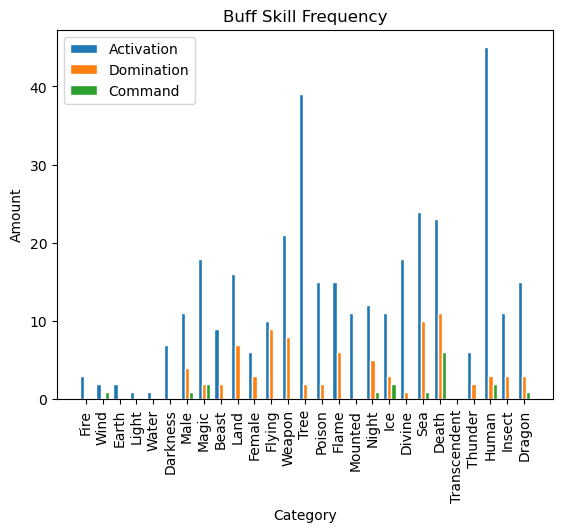

In [14]:
data = ui.generate_skill_frequency_data()
key = {
    "X Axis":"Category",
    "Y Axis":["Activation","Domination","Command"]
}

ui.graph_clustered_bar_graph(data,key)

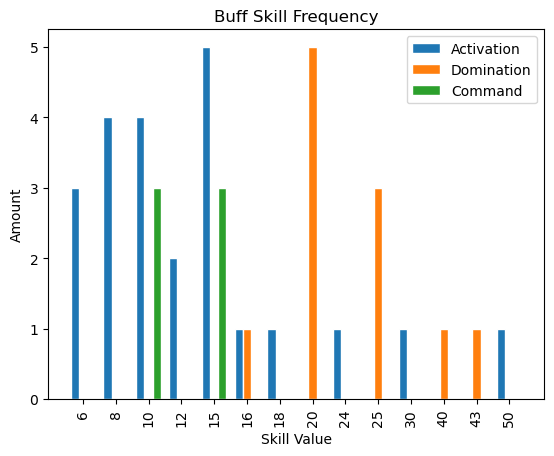

In [15]:
data = ui.generate_buff_value_frequency_data_by_race("死")
key = {
    "X Axis":"Skill Value",
    "Y Axis":["Activation","Domination","Command"]
}
ui.graph_clustered_bar_graph(data,key)

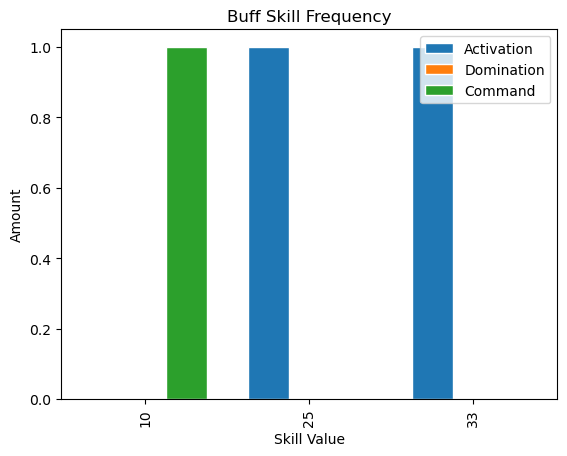

In [16]:
data = ui.generate_buff_value_frequency_data_by_element('風')
key = {
    "X Axis":"Skill Value",
    "Y Axis":["Activation","Domination","Command"]
}
ui.graph_clustered_bar_graph(data,key)

In [17]:
ui.sort_units_by_damage_potential(ui.unit_df)

,Name,Equipment Slots,Damage
0,ビッグバンドラゴン,"射撃,装飾",275.0
1,神威大蛇,"爪,獣装",261.8
2,テスカトリポカ,"爪,装飾",258.5
3,ヒルディス,"爪,獣装",253.0
4,酒呑童子,"両手,道具",237.6
5,混沌蟲アバドン,"爪,獣装",236.5
6,大百足姫,"爪,獣装",234.3
7,マシンサウルス,"爪,獣装",231.0
8,だいだらぼっち,"両手,装飾",231.0
9,ガイアスセイバー,"両手,鎧",231.0


In [18]:
names = ['ハーピー', 'ナラシンハ'] 
stat_vals = [10,38]
    
# selecting rows based on filter conditions
name_filter = ui.filter_df['Name'].isin(names)
stat_filter = ui.filter_df['Attack'].isin(stat_vals)
ui.filter_df[name_filter & stat_filter]

# ui.filter_df[ui.filter_df['Name'] == 'ハーピー']
# newdf = ui.filter_df[['Name','Attack']].copy()
# newdf

,Name,Element,Type,HP,Attack,Defense,Speed,Wisdom,Race,Race Advantage,Equipment Slots,Growth Rate,Cost,Skills,Leader Skills,Assist Skill,Governance Skill,Stance Skills,Recruitment Talismans,Recruitment Category
1,ハーピー,風,ブレイダー,85,10,7,26,6,"女,魔,獣,飛","人,男,陸","爪,獣装",S,1,"必殺増加[20],奇襲戦法[10],奇襲警戒[10],イベイド[30],側面攻撃[6],魅了攻撃[1]","多段攻撃[1],魅了攻撃[1]",速度布陣[10],農業[8],"進撃,混沌",獣,亜人
7,ナラシンハ,火,ブレイダー,105,38,34,14,6,"男,魔,獣,陸,騎","獣,器,樹,蟲","両手,鎧",A,6,"戦意高揚[50],カブト割[30],巨人狩り[50],特攻防御[40],反撃耐性[65],陸生活性[15],勇猛果敢,狂奔の牙[12]","集約攻撃,陸生指揮[15]",必殺増加[10],軍事[3],"進撃,混沌","力,獣,闘,歴",亜人


In [19]:
dir(widgets.Output)

['_Output__counter',
 '__annotations__',
 '__class__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_active_widgets',
 '_add_notifiers',
 '_all_trait_default_generators',
 '_append_stream_output',
 '_call_widget_constructed',
 '_comm_changed',
 '_compare',
 '_control_comm',
 '_default_keys',
 '_descriptors',
 '_dom_classes',
 '_flush',
 '_gen_repr_from_keys',
 '_get_embed_state',
 '_get_trait_default_generator',
 '_handle_control_comm_msg',
 '_handle_custom_msg',
 '_handle_msg',
 '_holding_sync',
 '_instance_inits',
 '_is_numpy',
 '_lock_property',
 '_log_default',
 '_model_module',
 '_model_module_version'

In [20]:
print(widgets.Output.__doc__)

Widget used as a context manager to display output.

    This widget can capture and display stdout, stderr, and rich output.  To use
    it, create an instance of it and display it.

    You can then use the widget as a context manager: any output produced while in the
    context will be captured and displayed in the widget instead of the standard output
    area.

    You can also use the .capture() method to decorate a function or a method. Any output
    produced by the function will then go to the output widget. This is useful for
    debugging widget callbacks, for example.

    Example::
        import ipywidgets as widgets
        from IPython.display import display
        out = widgets.Output()
        display(out)

        print('prints to output area')

        with out:
            print('prints to output widget')

        @out.capture()
        def func():
            print('prints to output widget')
    
